# ELM on CIFAR10

Review of convolutional ELMs:

I. R. Rodrigues, S. R. da Silva Neto, J. Kelner, D. Sadok, and P. T. Endo, _Convolutional Extreme Learning Machines: A Systematic Review_, Informatics **8**(2), 33 (2021). https://doi.org/10.3390/informatics8020033 (open access)

## Configuration

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

Configuration

In [2]:
DATA_DIR='./data'

IMAGE_SIZE = 32

NUM_CLASSES = 10
BATCH_SIZE = 128

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [4]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=transforms.ToTensor())
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

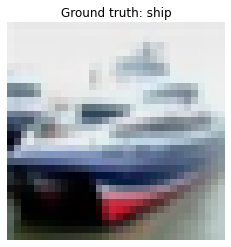

In [6]:
dataset_show_image(test_dset, 1)

In [7]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=False)

test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [8]:
class Net(nn.Module):
    def __init__(self, classes, image_size, channel_list, in_channels=3):
        super().__init__()
        
        layers = []
        for num, out_channels in enumerate(channel_list):
            if num > 0: layers.append(nn.MaxPool2d(2))
            layers += [
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.Tanh()
            ]
            in_channels = out_channels
        
        self.features = nn.Sequential(
            *layers,
            nn.Flatten()
        )
        
        reduced_size = image_size // 2**(len(channel_list) - 1)
        self.head = nn.Linear(in_channels * reduced_size**2, classes)
        
        self.reset_parameters()
    
    def forward(self, x):
        out = self.features(x)
        out = self.head(out)
        return out
    
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.normal_(m.bias, std=0.01)

In [9]:
model = Net(NUM_CLASSES, IMAGE_SIZE, channel_list = [128, 128, 256, 512])

In [10]:
model.to(DEVICE);

In [11]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 1,708,426


## Training

In [12]:
def create_matrices(model, loader, classes, device):
    HH = 0.
    HY = 0.
    with torch.no_grad():
        for X, Y in tqdm(loader):
            X, Y = X.to(device), Y.to(device)
            
            features = model.features(X)
            # add ones column for bias:
            ones = torch.ones(X.size(0), 1, device=device)
            features = torch.cat((features, ones), dim=1)
            
            HH = HH + features.T @ features
            Y_one_hot = F.one_hot(Y, classes)
            HY = HY + features.T @ Y_one_hot.float()
    
    return HH, HY

In [13]:
def solve_linear(HH, HY, device, α=0.):
    n = HH.size(0)
    HH_reg = HH + α * torch.eye(n, device=DEVICE) # add regularization
    sol = torch.linalg.lstsq(HH_reg, HY)
    B = sol.solution
    return B

In [14]:
def update_model(model, B):
    model.head.weight.data = B[:-1].T
    model.head.bias.data = B[-1]

In [15]:
def train(model, loader, classes, device, α=0.):
    HH, HY = create_matrices(model, loader, classes, device)
    B = solve_linear(HH, HY, device, α)
    update_model(model, B)

In [16]:
train(model, train_loader, NUM_CLASSES, DEVICE, α=0.00001)

100%|█████████████████████████████████████████| 391/391 [00:04<00:00, 93.80it/s]


## Testing

In [17]:
def evaluate(model, loader, device):
    num_correct = 0
    num_total = 0
    with torch.no_grad():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            out = model(X)
            pred_labels = torch.argmax(out, dim=1)
            num_correct += (pred_labels == Y).sum().item()
            num_total += X.size(0)
    
    acc = num_correct / num_total
    return acc

In [21]:
acc = evaluate(model, test_loader, DEVICE)
print(f"Accuracy {acc:.3f}")

Accuracy 0.638


Using gradient descent: accuracy 0.807